In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from multirotor.controller import PIDController

In [2]:
controller_in = pd.read_csv('../data/controller_in.csv', header=None).to_numpy()
controller_out = pd.read_csv('../data/controller_out.csv', header=None).to_numpy()

In [3]:
pos_pid = PIDController(k_p=[0.3,0.3,0.2], k_i=0, k_d=0, max_err_i=0)
vel_pid = PIDController(k_p=[1, 1, 100], k_i=[0.01, 0.01, 0], k_d=0, max_err_i=15)

In [4]:
def pos_controller(ref_pos, pos, pos_pid: PIDController):
    ref_vel = pos_pid.step(ref_pos, pos, dt=0.01)
    return ref_vel

def vel_leash(ref_vel, eul, max_vel):
    The = eul[1]
    Phi = eul[0]
    Psi = eul[2]
    R_b_e = np.array([[np.cos(Psi)*np.cos(The), np.cos(Psi)*np.sin(The)*np.sin(Phi)-np.sin(Psi)*np.cos(Phi), np.cos(Psi)*np.sin(The)*np.cos(Phi)+np.sin(Psi)*np.sin(Phi)],
                  [np.sin(Psi)*np.cos(The), np.sin(Psi)*np.sin(The)*np.sin(Phi)+np.cos(Psi)*np.cos(Phi), np.sin(Psi)*np.sin(The)*np.cos(Phi)-np.cos(Psi)*np.sin(Phi)],
                  [-np.sin(The), np.cos(The)*np.sin(Phi), np.cos(The)*np.cos(Phi)]])
    
    velbody = R_b_e.T @ ref_vel
    velbody = velbody[0:2]

    norm = np.linalg.norm(velbody)
    if norm > max_vel:
        velbody = velbody * (max_vel / norm)

    return velbody

def vel_controller(ref_vel, vel, vel_pid: PIDController):
    angle_ref = vel_pid.step(ref_vel, vel, dt=0.01)
    angle_ref[0:2] = np.clip(angle_ref[0:2], -22.5*np.pi/180, 22.5*np.pi/180) # TODO: degrees and radians mixed
    angle_ref[1] *= -1
    angle_ref[2] += 9.8*10.66
    return angle_ref

def angle_controller(theta_phi_ref, eul):
    angle_ref = np.array([theta_phi_ref[0], theta_phi_ref[1], 0])
    err = angle_ref - eul
    return err * 5

def rate_controller(rate_ref, rate):
    err = rate_ref - rate
    return err * 8

def allocate_control_matlab(thrust: float, torques: np.ndarray) -> np.ndarray:
        """
        Allocate control to propellers by converting prescribed forces and torqes
        into propeller speeds. Uses the control allocation matrix.

        Parameters
        ----------
        thrust : float
            The thrust in the body z-direction.
        torques : np.ndarray
            The roll, pitch, yaw torques required about (x, y, z) axes.

        Returns
        -------
        np.ndarray
            The prescribed propeller speeds (rad /s)
        """
        l=0.635
        b=9.8419e-05
        d=1.8503e-06

        angsm = np.cos(np.pi/8)
        anglg = np.cos(3*np.pi/8)
        
        A_f = np.array([[b, b, b, b, b, b, b, b],
                       [-b*l*anglg, -b*l*angsm, b*l*angsm, b*l*anglg, b*l*anglg, b*l*angsm, -b*l*angsm, -b*l*anglg],
                       [-b*l*angsm, -b*l*anglg, -b*l*anglg, -b*l*angsm, b*l*angsm, b*l*anglg, b*l*anglg, b*l*angsm],
                       [d, -d, d, -d, d, -d, d, -d]], dtype=np.float32)
        
        u_des = np.array([thrust, torques[0], torques[1], torques[2]], dtype=np.float32)
        
        a = np.linalg.pinv(A_f)
        Omega_s = np.linalg.pinv(A_f) @ np.expand_dims(u_des, 1)
        
        wref = np.zeros(8)
        for i in range(len(Omega_s)):
            if Omega_s[i] < 0:
                wref[i] = 0
            elif Omega_s[i] > 670**2:
                wref[i] = 670
            else:
                wref[i] = np.sqrt(Omega_s[i])
        
        return np.round(wref, 1)

In [5]:
def cascade_pid(ref_pos, vel, pos, eul, rate, pos_pid, vel_pid):
    max_vel = 15 # make a parameter

    inert_ref_vel = pos_controller(ref_pos, pos, pos_pid)
    inert_ref_vel = np.clip(inert_ref_vel, -max_vel, max_vel)
    body_ref_vel_leashed = vel_leash(inert_ref_vel, eul, max_vel)
    ref_vel = np.array([body_ref_vel_leashed[0], body_ref_vel_leashed[1], inert_ref_vel[2]])
    

    angle_ref = vel_controller(ref_vel, vel, vel_pid)
    
    zforce_ref = angle_ref[2]

    theta_phi_ref = angle_ref[[1,0]] # swap roll and pitch
    rate_ref = angle_controller(theta_phi_ref, eul)

    torque_ref = rate_controller(rate_ref, rate)

    return allocate_control_matlab(zforce_ref, torque_ref), angle_ref

In [6]:
speeds = []
ref_vels = []
for state in controller_in:
    speed, ref_vel = cascade_pid(state[0:3], state[3:6], state[6:9], state[9:12], state[12:15], pos_pid, vel_pid)
    speeds.append(speed)
    ref_vels.append(ref_vel)

speeds = np.array(speeds)

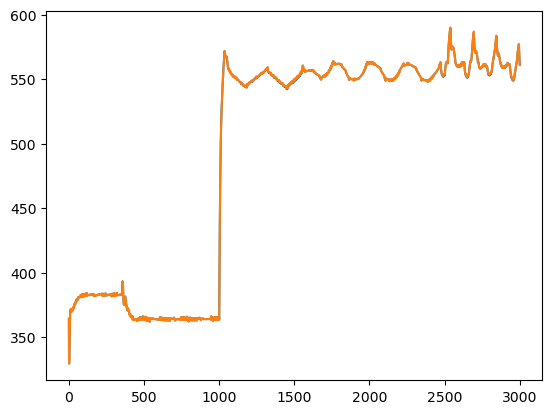

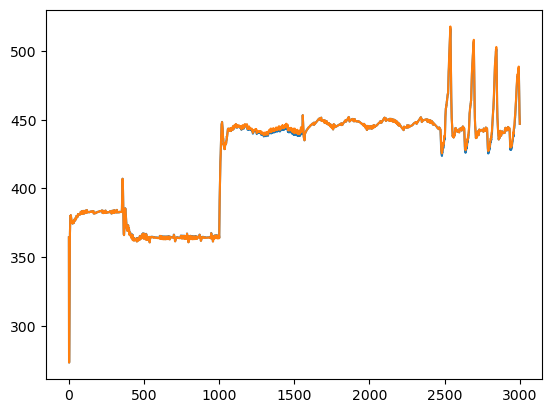

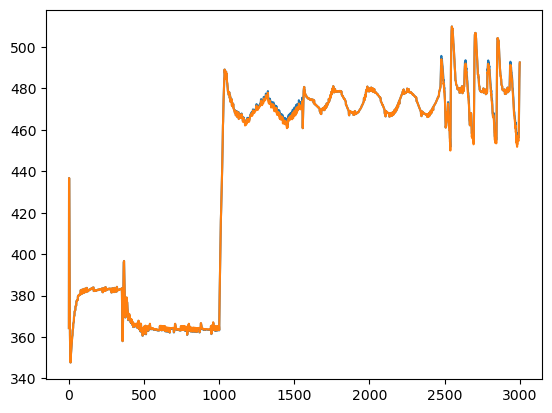

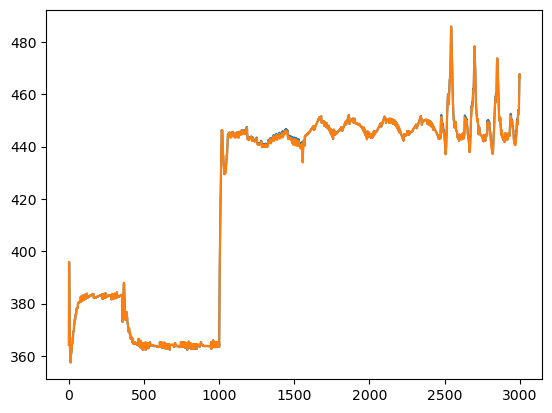

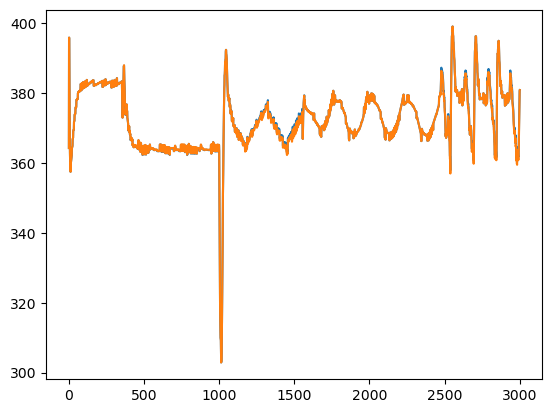

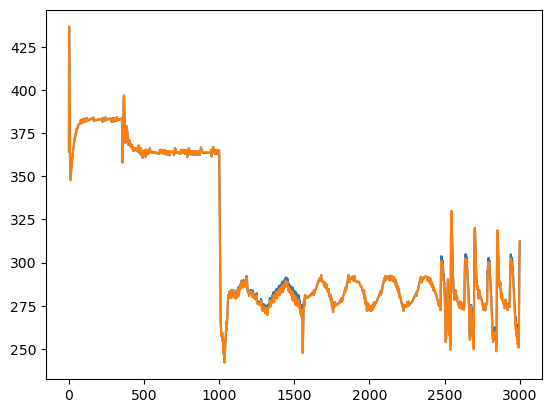

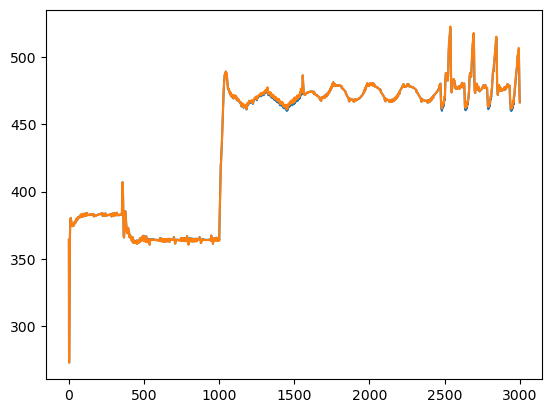

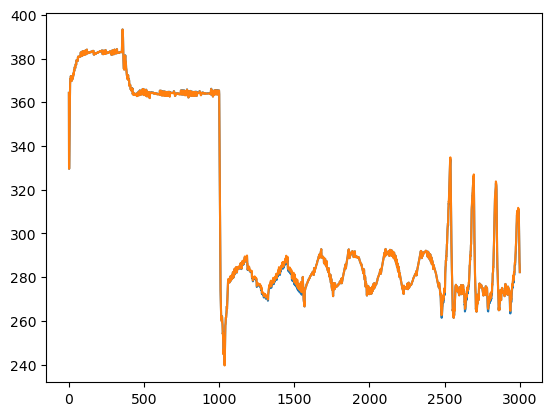

In [10]:
for i in range(8):
    plt.plot(speeds[:,i])
    plt.plot(controller_out[:,i])
    plt.show()

(0.0, 1000.0)

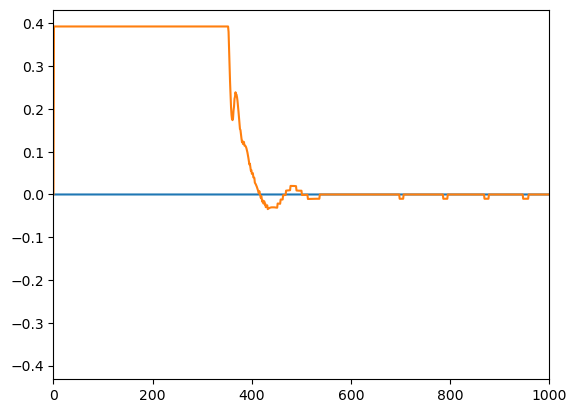

In [8]:
plt.plot(np.array(ref_vels)[:,0:2])
plt.xlim(0,1000)